In [2]:
import sys
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

In [3]:
from notebooks.notebooks_utils import get_activation, load_checkpoint

job_id = "4344494" # faenet

trainer = load_checkpoint(job_id)
train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])


🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4344494/checkpoints/checkpoint-0021588.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

In [4]:
from notebooks.notebooks_utils import oc20_to_graph, plot_element_3d, process_datapoint

In [5]:
from sklearn.cluster import KMeans

def cluster_molecule_graph(x_processed):
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    _ = kmeans.fit_transform(x_processed.pos.detach().cpu().numpy())

    clusters = kmeans.labels_
    centers = kmeans.cluster_centers_
    distance_to_center = np.linalg.norm(x_processed.pos.detach().cpu().numpy() - centers[clusters], axis=1)

    j = 0
    nodes = np.arange(len(clusters))
    orders = np.zeros_like(clusters)
    for i in range(n_clusters):
        cluster_range = np.arange(j, j + (clusters == i).sum())
        orders[cluster_range] = nodes[clusters==i][np.argsort(distance_to_center[clusters == i])]
        j = j + (clusters == i).sum()

    plot_element_3d(data_graph, order=orders, clusters=clusters)

    return orders, clusters


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

plt.rc("animation", html="html5")

def plot_pca(model_name, base_activation, reorder=None):
    if reorder is None:
        reorder = np.arange(len(base_activation["InteractionBlock_0"]))
    key = "InteractionBlock_0"
    h = base_activation[key].cpu().numpy()[reorder]

    fig, ax = plt.subplots()

    pca = PCA(n_components=2)
    pca.fit(h)
    h_pca = pca.transform(h)
    # ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))
    ax.scatter(h_pca[:, 0], h_pca[:, 1], c=atomic_numbers)
    ax.set_title(f"{model_name} - PCA of hidden states")
    ax.set_ylabel(f"{key}")

    def update(key):
        if "EmbeddingBlock" in key: #only for faenet
            h = base_activation[key][0].cpu().numpy()[reorder]
        else:
            h = base_activation[key].cpu().numpy()[reorder]

        pca = PCA(n_components=2)
        pca.fit(h)
        h_pca = pca.transform(h)
        ax.clear()
        # ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))   
        ax.scatter(h_pca[:, 0], h_pca[:, 1], c=atomic_numbers)
        ax.set_title(f"{model_name} - PCA of hidden states")
        ax.set_ylabel(f"{key}")

        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)

    return ani


In [7]:
%matplotlib inline

plt.rc("animation", html="html5")

# compare the embeddings of the same atom in different blocks
def plot_embeddings(model_name, base_activation, reorder=None):
    if reorder is None:
        reorder = np.arange(len(base_activation["InteractionBlock_0"]))
    fig, ax = plt.subplots()

    for i in range(min(10, base_activation["InteractionBlock_0"].shape[0])):
        ax.plot(base_activation["InteractionBlock_0"][i, :].cpu().numpy()[reorder], label=f"Atom {i}", alpha=0.5)
    ax.set_xlabel("Hidden dimension")
    ax.set_ylabel("Activation")
    ax.set_title(f"{model_name} - Embeddings for atom {i}")
    ax.set(ylim=(-2, 2))
    ax.legend()

    def update(key):
        if "Embed" in key:
            h = base_activation[key][0].cpu().numpy()[reorder]
        else:
            h = base_activation[key].cpu().numpy()[reorder]
        ax.clear()
        for i in range(min(10, h.shape[0])):
            ax.plot(h[i, :], label=f"Atom {i}", alpha=0.5)
        ax.set_xlabel("Hidden dimension")
        ax.set_ylabel(f"{key}")
        ax.set_title(f"{model_name} - Embeddings for atom {i}")
        ax.set(ylim=(-3, 3))
        ax.legend()
        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)
    return ani


In [33]:
from collections import defaultdict

def plot_std_interactions(trainer, activations_dict, title="FAENet", type_="base"):
    activations_list = []
    train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

    with torch.no_grad():
        for i, x in enumerate(train_loader):
            if i == 1000:
                break
            base_output = trainer.model_forward(x)
            activations_list.append(deepcopy(activations_dict))

    blocks_std = defaultdict(list)
    blocks_mean = defaultdict(list)

    for activations_dict in activations_list:
        for i, (block, activations) in enumerate(activations_dict.items()):
            if "Embed" not in block:
                if type_ == "ewald":
                    if "Ewald" not in block:
                        continue
                    # plt.plot(activations[0].std(0).cpu().numpy(), label=block)
                    blocks_std[block].append(activations[0].std(0).mean().cpu().numpy())
                    blocks_mean[block].append(activations[0].mean(0).mean(0).cpu().numpy())
                else:
                    if "Ewald" in block:
                        continue
                    # plt.plot(activations.std(0).cpu().numpy(), label=block)
                    blocks_std[block].append(activations.std(0).mean().cpu().numpy())
                    blocks_mean[block].append(activations.mean(0).mean(0).cpu().numpy())
    # plt.plot(standard_deviations)
    # plt.legend()
    # plt.title(f"{title} - Standard deviation of activations over atoms for each block")
    # plt.xlabel("Hidden dimension")
    # plt.ylabel("Standard deviation")
    # plt.show()
    standard_deviations = [np.array(v) for v in blocks_std.values()]
    means = [np.array(v) for v in blocks_mean.values()]
    print(np.array(standard_deviations).shape)
    standard_deviations = np.array(standard_deviations).mean(1)
    means = np.array(means).mean(1)

    plt.plot(standard_deviations)
    plt.title(f"{title} - Mean of Standard deviation for each block")
    plt.xlabel("Block")
    plt.ylabel("Mean of standard deviation")
    plt.show()

    plt.plot(means)
    plt.title(f"{title} - Mean of mean for each block")
    plt.xlabel("Block")
    plt.ylabel("Mean of mean")
    plt.show()

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sns.set_theme()

def plot_similarity_matrix(activations_dict, orders=None, type_="base"):
    if orders is None:
        orders = np.arange(len(activations_dict["InteractionBlock_0"]))

    fig, axs = plt.subplots(2, 3, figsize=(15, 7))

    i = -1
    for key, embedding_step in activations_dict.items():
        if type_ == "ewald":
            if "Ewald" not in key and "Embed" not in key:
                continue
        else:
            if "Ewald" in key:
                continue
        i += 1
        ax = axs[i // 3, i % 3]
        try:
            h = embedding_step.detach().cpu().numpy()[orders]
        except:
            h = embedding_step[0].detach().cpu().numpy()[orders]

        cosine_similarity_matrix = cosine_similarity(h, h)
        ax.set_title(f"Similarity matrix for {key}")
        sns.heatmap(cosine_similarity_matrix, ax=ax, cmap="viridis")
    fig.tight_layout()
    fig.show()

# h_prev = activations_dict["EmbeddingBlock"][0].cpu().numpy()[orders]
# key_prev = "EmbeddingBlock"
# for key, embedding_step in activations_dict.items():
#     if "EmbeddingBlock" in key:
#         continue
#     h = embedding_step.detach().cpu().numpy()[orders]

#     cosine_similarity_matrix = cosine_similarity(h_prev, h)
#     fig, ax = plt.subplots()
#     ax.set_title(f"Similarity matrix for {key} and {key_prev}")
#     sns.heatmap(cosine_similarity_matrix, ax=ax, cmap="viridis")
#     fig.tight_layout()
#     fig.show()

#     h_prev = h
#     key_prev = key

    

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

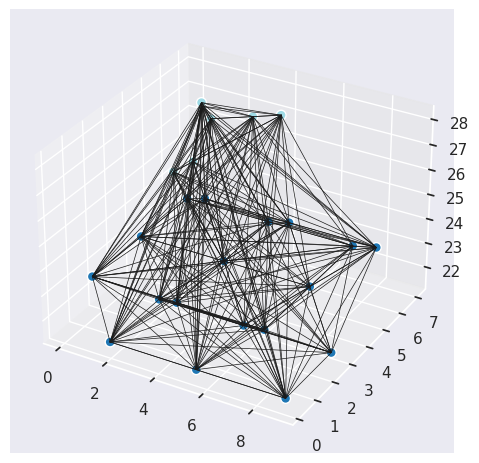

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

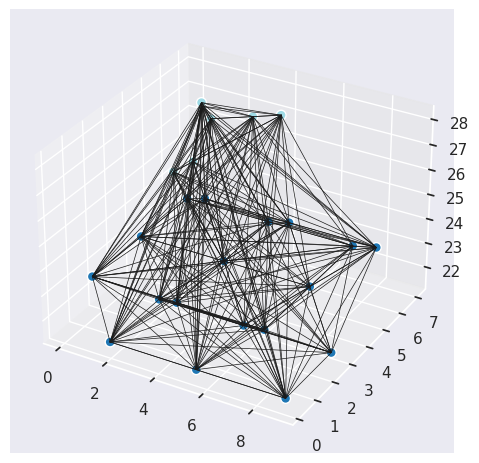

In [10]:
activations_dict = {}

trainer.model.module.embed_block.register_forward_hook(get_activation(f"{trainer.model.module.embed_block.__class__.__name__}", activations_dict))

for i, block in enumerate(trainer.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict))

with torch.no_grad():
    i = 20
    for i, x in enumerate(train_loader):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer)
    atomic_numbers = x[0].atomic_numbers
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer.model_forward(x)

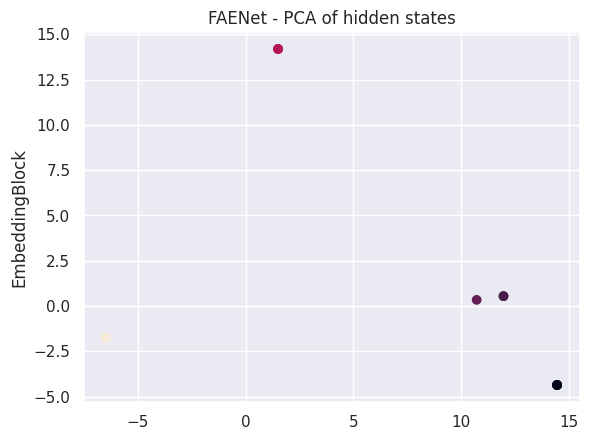

In [11]:
ani = plot_pca("FAENet", activations_dict)
ani

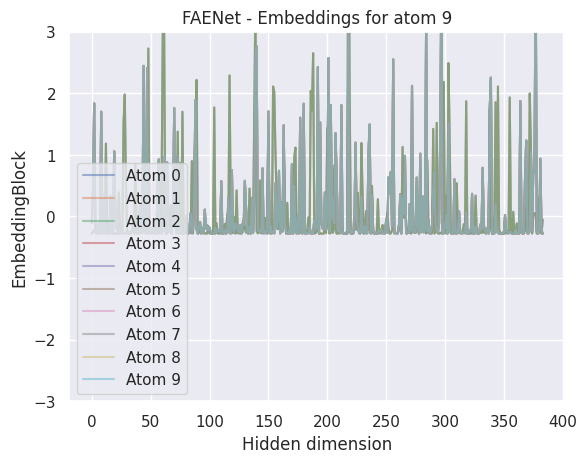

In [12]:
ani = plot_embeddings("FAENet", activations_dict, reorder=None)
ani

(5, 10)


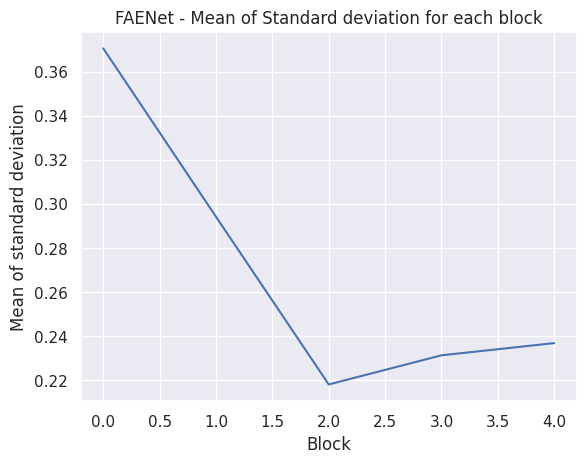

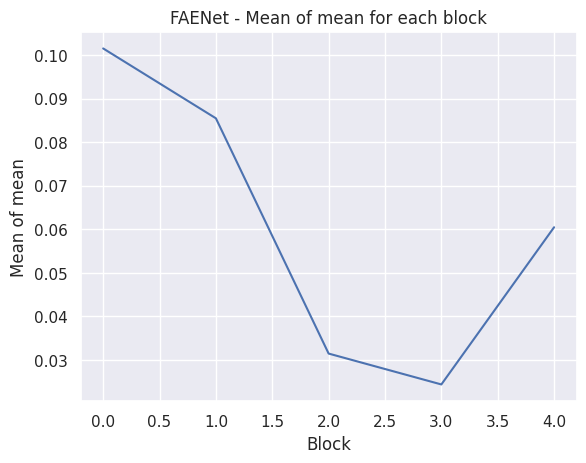

In [34]:
plot_std_interactions(trainer, activations_dict)

In [ ]:
plot_similarity_matrix(activations_dict, None)

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

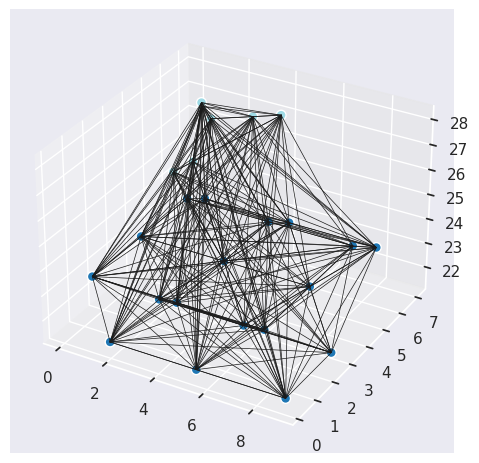

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

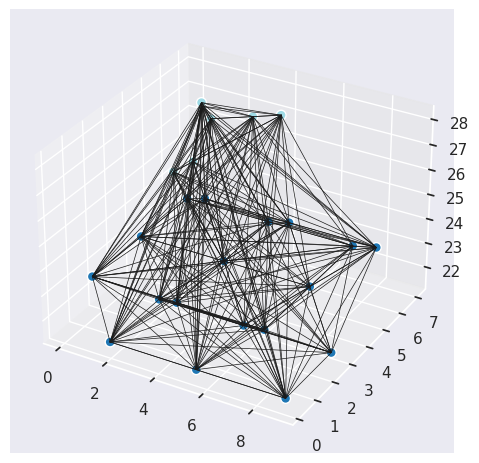

In [51]:
# job_id = "4123618" #schnet
job_id = "4123617" #schnet

trainer_schnet = load_checkpoint(job_id)
train_loader_schnet = trainer_schnet.get_dataloader(trainer_schnet.datasets["train"], trainer_schnet.samplers["train"])

activations_dict_schnet = {}

trainer_schnet.model.module.embedding.register_forward_hook(get_activation(f"{trainer_schnet.model.module.embedding.__class__.__name__}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.interactions):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))

with torch.no_grad():
    i = 20
    for i, x in enumerate(train_loader_schnet):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer_schnet)
    atomic_numbers = x[0].atomic_numbers
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer_schnet.model_forward(x)

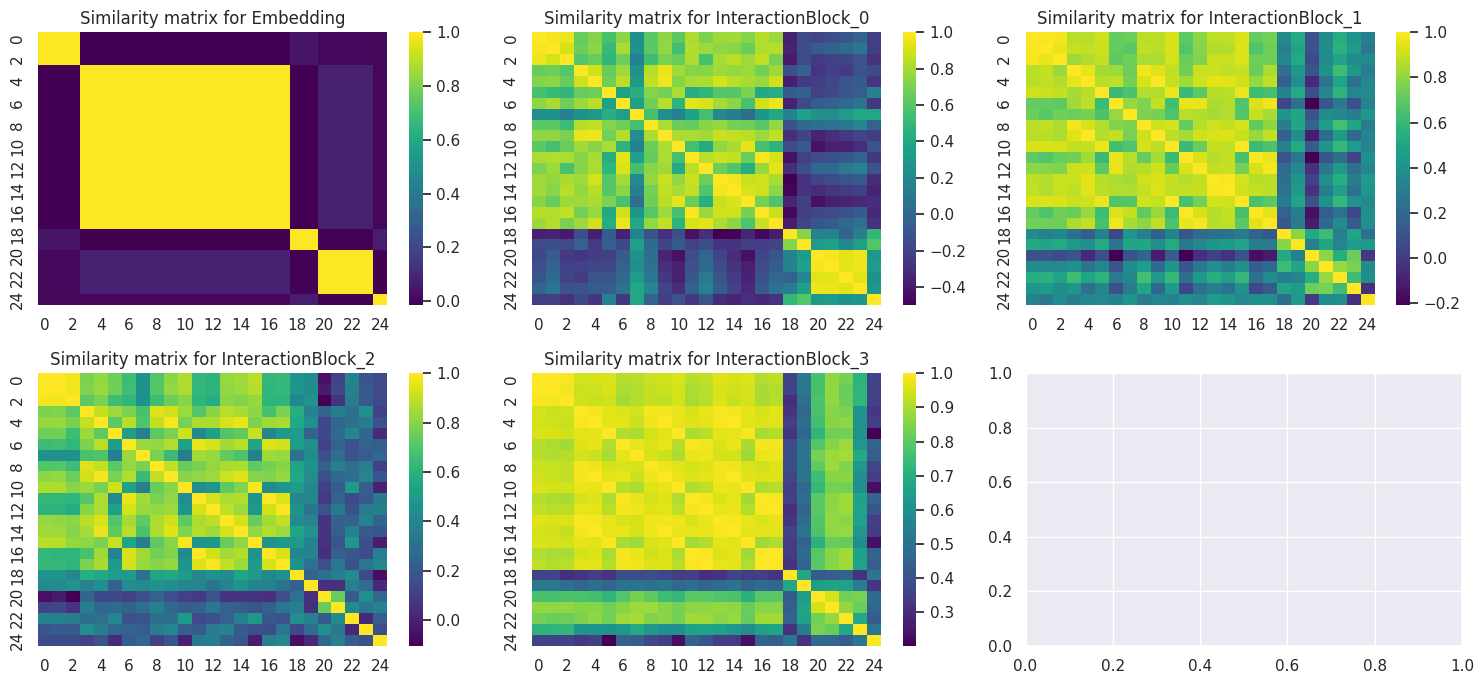

In [52]:
plot_similarity_matrix(activations_dict_schnet, None)

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4119577/checkpoints/checkpoint-0043164.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

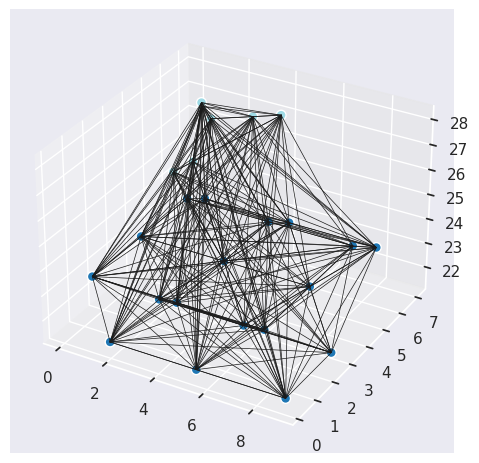

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

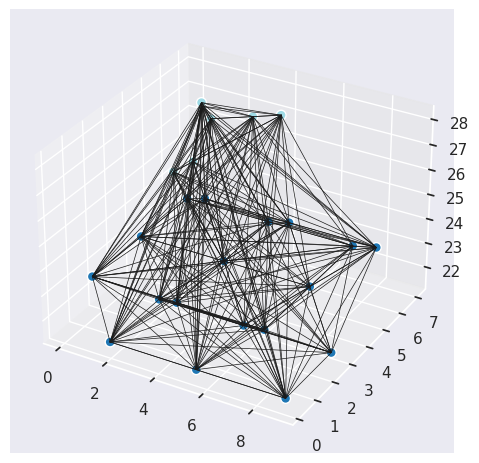

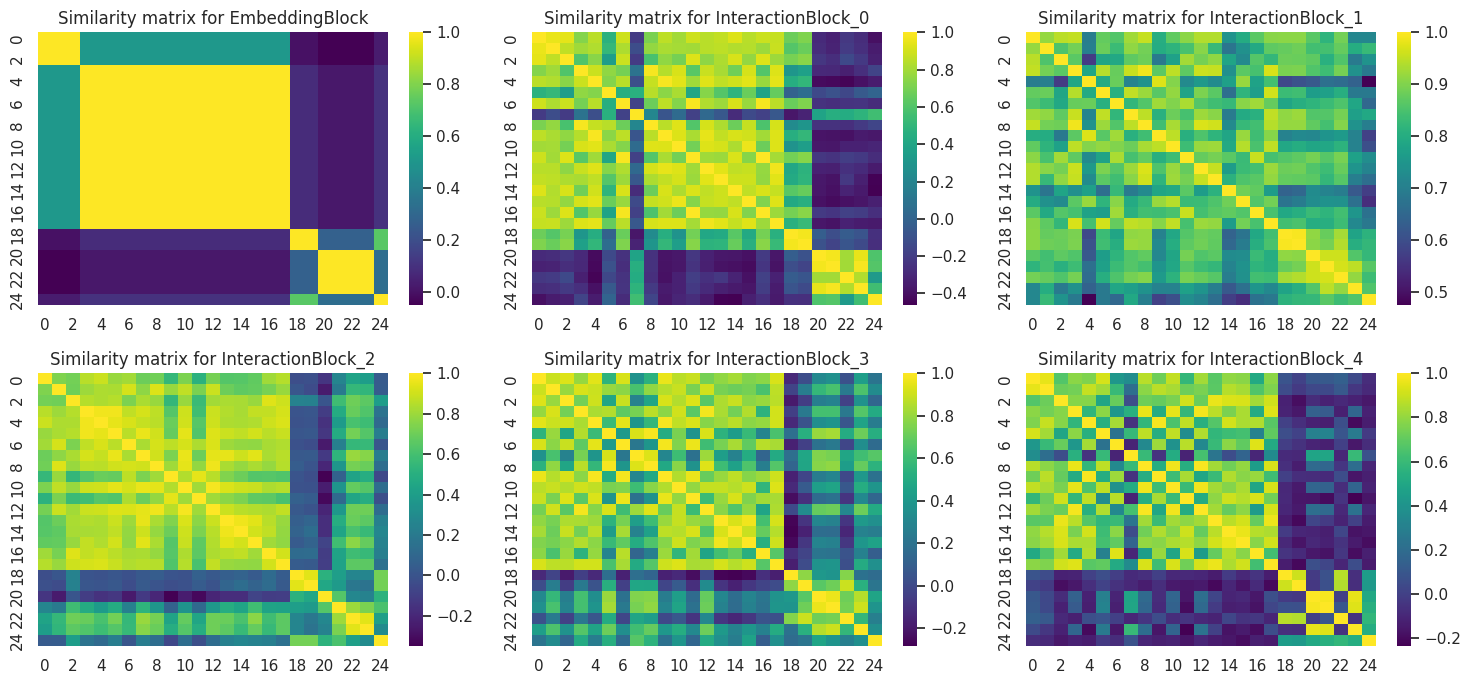

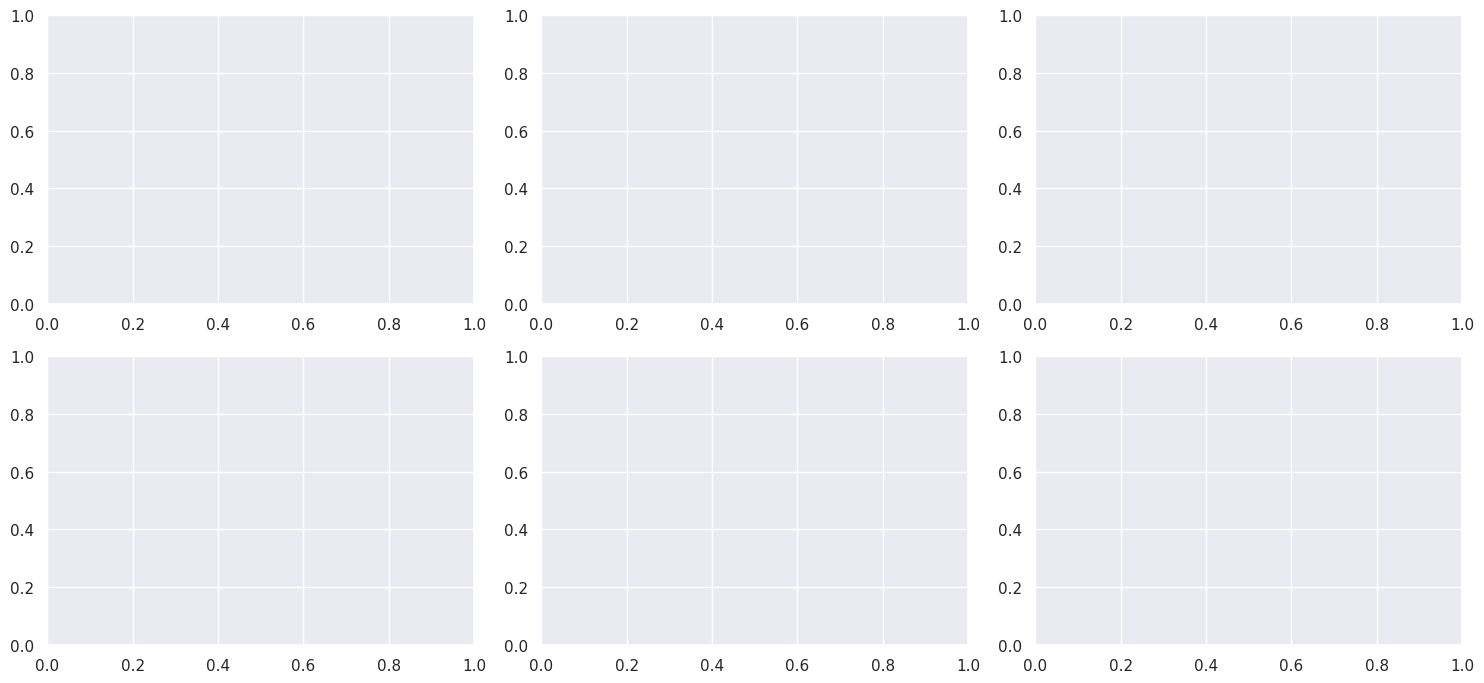

In [59]:
job_id = "4119577" #faenet + ewald

trainer_schnet = load_checkpoint(job_id)
train_loader_schnet = trainer_schnet.get_dataloader(trainer_schnet.datasets["train"], trainer_schnet.samplers["train"])

activations_dict_schnet = {}

trainer_schnet.model.module.embed_block.register_forward_hook(get_activation(f"{trainer_schnet.model.module.embed_block.__class__.__name__}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.ewald_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))


with torch.no_grad():
    i = 20
    for i, x in enumerate(train_loader_schnet):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer_schnet)
    atomic_numbers = x[0].atomic_numbers
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer_schnet.model_forward(x)


In [69]:
activations_dict_schnet

{'EmbeddingBlock': (tensor([[-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          [-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          [-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          ...,
          [-0.2354, -0.0557, -0.2452,  ..., -0.0529, -0.2776, -0.1230],
          [-0.2354, -0.0557, -0.2452,  ..., -0.0529, -0.2776, -0.1230],
          [-0.1432, -0.0830, -0.2633,  ..., -0.1962, -0.2666, -0.0888]],
         device='cuda:0'),
  tensor([[ 0.3147,  0.0401, -0.0697,  ...,  0.0107, -0.0985, -0.0400],
          [ 0.1147,  0.0580, -0.2065,  ...,  0.0107, -0.0985, -0.0400],
          [ 0.1886,  0.0161, -0.0951,  ...,  0.0107, -0.0985, -0.0400],
          ...,
          [-0.2566, -0.0852,  0.1127,  ...,  0.0417,  0.2327, -0.0068],
          [-0.2105, -0.0662, -0.0175,  ...,  0.0476,  0.2770,  0.0207],
          [-0.0724, -0.1386,  1.1310,  ...,  0.0135,  0.4812, -0.0601]],
         device='cuda:0')),
 'EwaldBlock_0': (tensor([[-0.2

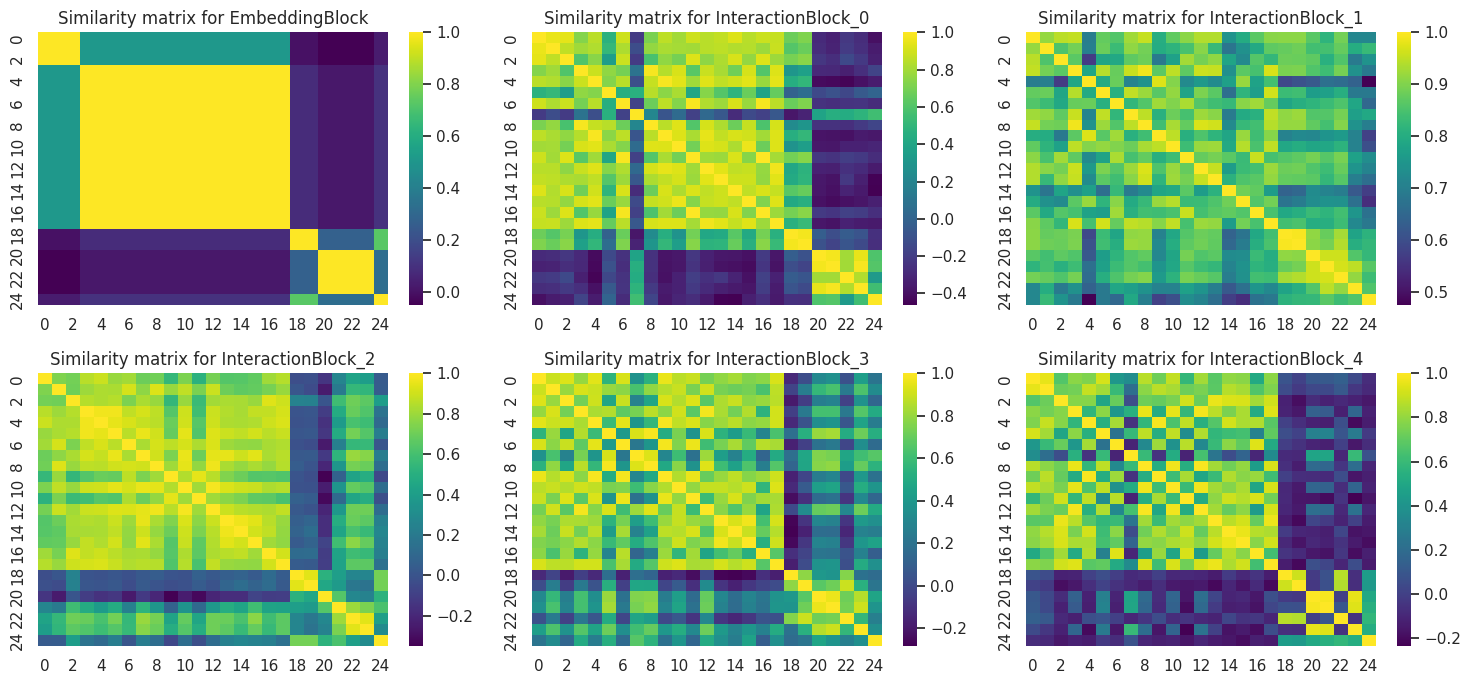

In [79]:
plot_similarity_matrix(activations_dict_schnet, None, type_="base")

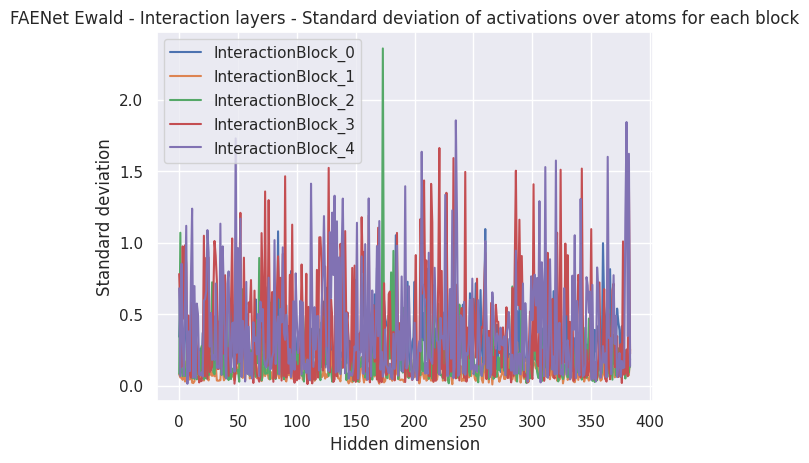

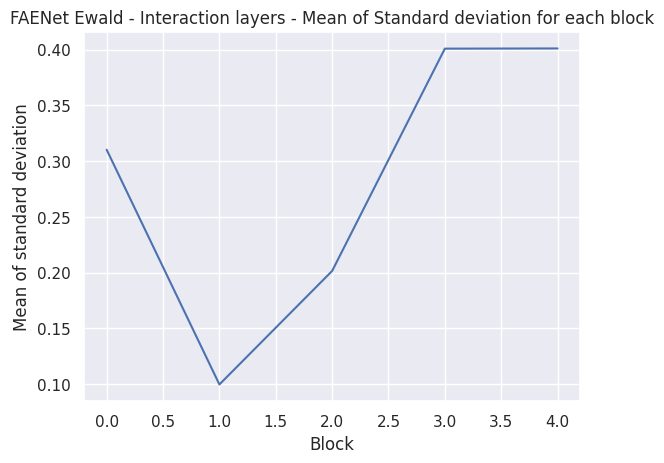

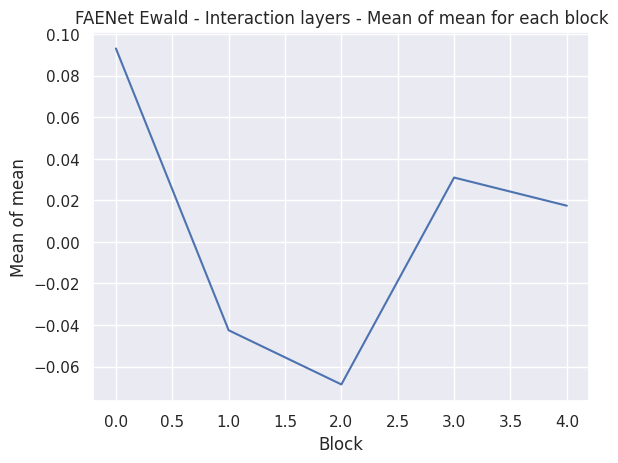

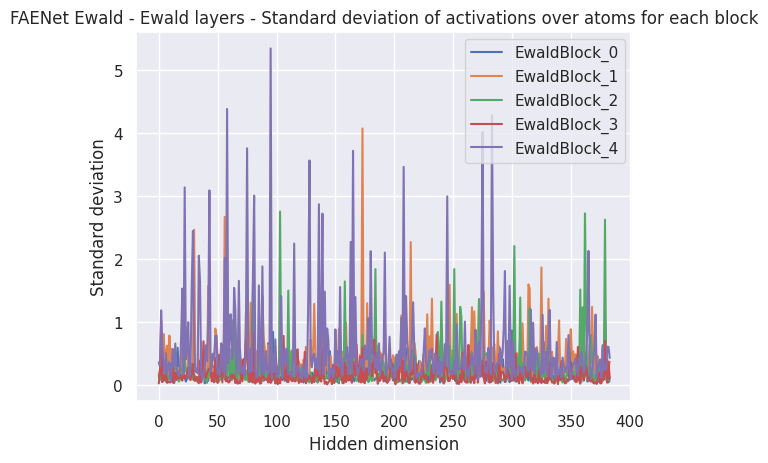

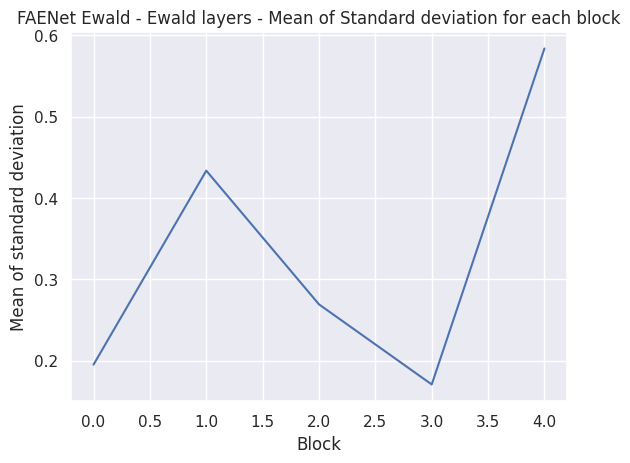

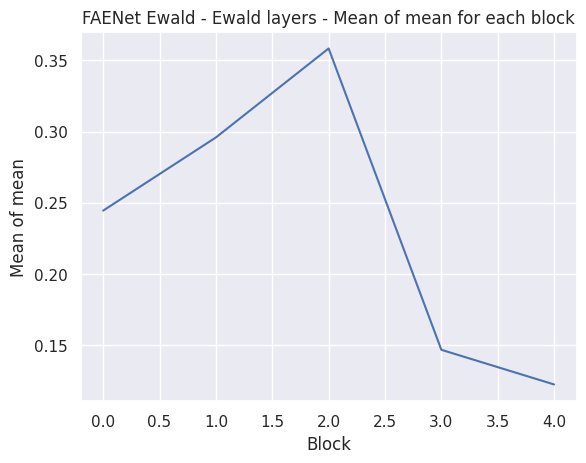

In [87]:
plot_std_interactions(trainer_schnet, activations_dict_schnet, title="FAENet Ewald - Interaction layers", type_="base")
plot_std_interactions(trainer_schnet, activations_dict_schnet, title="FAENet Ewald - Ewald layers", type_="ewald")

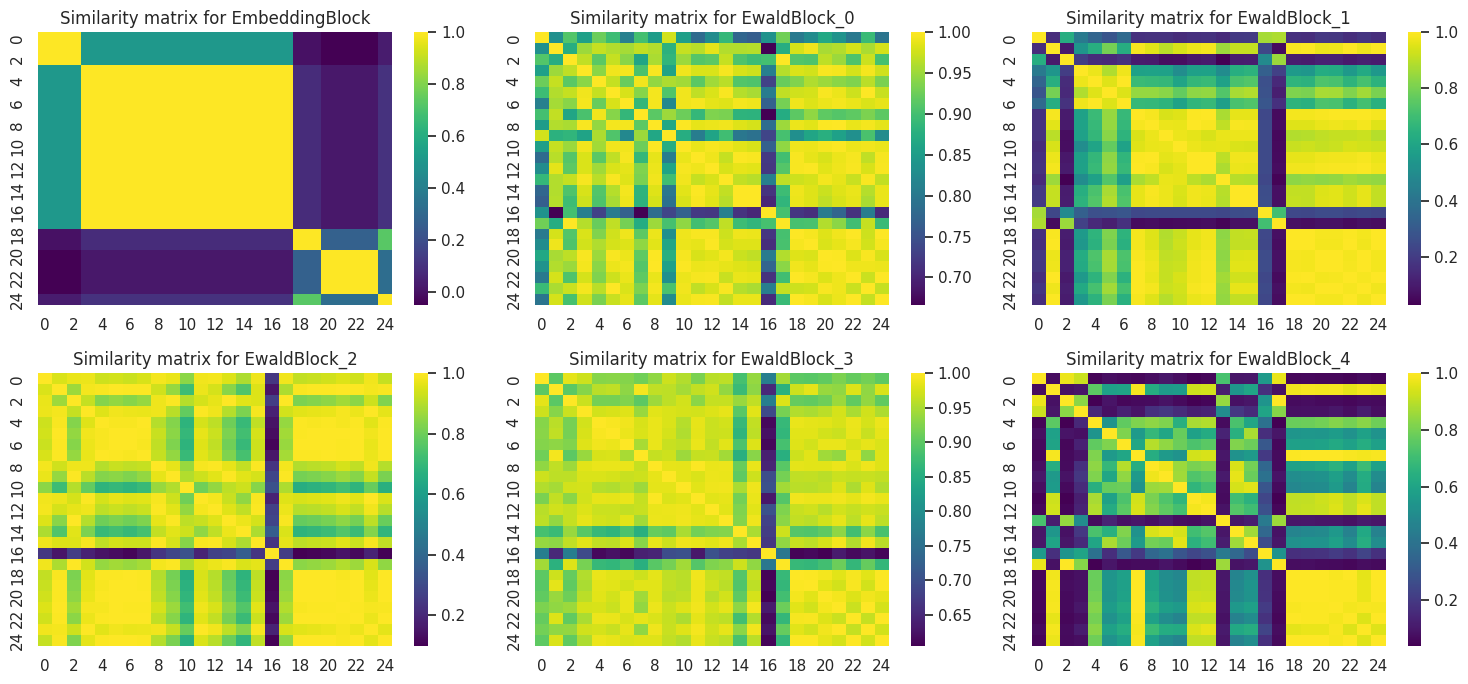

In [75]:
plot_similarity_matrix(activations_dict_schnet, None, type_="ewald")